# AI501 Assignment 5: Artitificial Neural Networks



## Import Modules

In [ ]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

torch.manual_seed(0)

## Connect to Your Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

Mounted at /gdrive


## Set Hyperparameters

In [ ]:
#########################
# examples
max_epoch = 10
learning_rate = 0.001
batch_size = 128
#########################
device = 'cuda'

## Construct Data Pipeline
*DO NOT MODIFY THIS SECTION FOR EFFICIENT GRADING*

In [4]:
data_dir = os.path.join(gdrive_root, 'AI501HW5')

train_dataset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root=data_dir, train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ("0","1","2","3","4","5","6","7","8","9")

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /gdrive/My Drive/AI501HW5/MNIST/raw/train-images-idx3-ubyte.gz to /gdrive/My Drive/AI501HW5/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /gdrive/My Drive/AI501HW5/MNIST/raw/train-labels-idx1-ubyte.gz to /gdrive/My Drive/AI501HW5/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /gdrive/My Drive/AI501HW5/MNIST/raw/t10k-images-idx3-ubyte.gz to /gdrive/My Drive/AI501HW5/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /gdrive/My Drive/AI501HW5/MNIST/raw/t10k-labels-idx1-ubyte.gz to /gdrive/My Drive/AI501HW5/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


##Define a Model

In [16]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        ##################################
        # assign your layer components. refer to "torch.nn"
        self.conv=nn.Sequential(
            nn.Conv2d(1,32,3,1,1),nn.ReLU(),nn.Conv2d(32,32,3,1,1),nn.ReLU(),
            nn.MaxPool2d(2,2), #28->14
            nn.Conv2d(32,64,3,1,1),nn.ReLU(),nn.Conv2d(64,64,3,1,1),nn.ReLU(),
            nn.MaxPool2d(2,2), #14->7
        )
        self.fc=nn.Sequential(
            nn.Linear(7*7*64,2048),nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2048,2048),nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2048,10)
        )
        ##################################

    def forward(self, x):
        ##################################
        # stack the components (example: Convolutional NN -> Flatten -> Multi-layer Perceptron)
        x=self.conv(x)
        x=torch.flatten(x,1)
        outputs=self.fc(x)
        ##################################
        return outputs

##Initilize the model and optimizer

In [17]:
model = Classifier().to(device)
print("Model Structure")
print(model)

criterion=nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Model Structure
Classifier(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=2048, out_features=10, bias=True)
  )
)


##Define the Training Procedure

In [23]:
def train(epoch):
    model.train()
    train_loss=0
    for i, (x, y) in enumerate(train_loader):
        inputs = x.to(device)
        labels = y.to(device)
        ####################################
        # write your training logic
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*x.size(0)
        ####################################
        if i % (len(train_loader.dataset)//batch_size//4) == 0:
            print('[epoch{:3d}] train loss {:.4f}'.format(epoch, loss.item()))
    train_loss/=len(train_loader.dataset)
    return train_loss

##Define the Testing Procedure

In [24]:
def test(epoch):
    model.eval()
    test_loss = 0
    test_accuracy = 0
    for i, (x, y) in enumerate(test_loader):
        inputs = x.to(device)
        labels = y.to(device)
        ####################################
        # write your testing logic
        outputs=model(inputs)
        loss=criterion(outputs,labels)
        correct=torch.argmax(outputs,1)==labels
        accuracy=correct.float().mean()
        ####################################
        test_loss += loss.item()*x.size(0)
        test_accuracy += accuracy.item()*x.size(0)
    
    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    print('[epoch{:3d}] test loss {:.4f} test accuracy {:.4f}'.format(epoch, test_loss, test_accuracy))
    return test_loss

##Training the model

In [25]:
# Training
train_losses=[]
test_losses=[]
for epoch in range(max_epoch):
    train_losses.append(train(epoch))
    test_losses.append(test(epoch))

[epoch  0] train loss 2.3176
[epoch  0] train loss 0.1172
[epoch  0] train loss 0.2315
[epoch  0] train loss 0.0743
[epoch  0] train loss 0.0374
[epoch  0] test loss 0.0702 test accuracy 0.9777
[epoch  1] train loss 0.1705
[epoch  1] train loss 0.0822
[epoch  1] train loss 0.0682
[epoch  1] train loss 0.0389
[epoch  1] train loss 0.0974
[epoch  1] test loss 0.0363 test accuracy 0.9882
[epoch  2] train loss 0.0396
[epoch  2] train loss 0.0522
[epoch  2] train loss 0.0343
[epoch  2] train loss 0.0400
[epoch  2] train loss 0.1077
[epoch  2] test loss 0.0256 test accuracy 0.9915
[epoch  3] train loss 0.0270
[epoch  3] train loss 0.0463
[epoch  3] train loss 0.0634
[epoch  3] train loss 0.0120
[epoch  3] train loss 0.0540
[epoch  3] test loss 0.0348 test accuracy 0.9888
[epoch  4] train loss 0.0706
[epoch  4] train loss 0.0079
[epoch  4] train loss 0.0113
[epoch  4] train loss 0.0104
[epoch  4] train loss 0.0630
[epoch  4] test loss 0.0371 test accuracy 0.9893
[epoch  5] train loss 0.0070
[

## Classify a given data

label : 3
prediction : 3


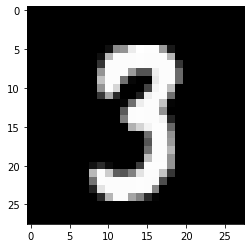

In [32]:
import random
import matplotlib.pyplot as plt
import numpy as np

model.eval()
random_idx = random.randint(0, len(test_loader.dataset))
test_input, test_label = test_dataset.__getitem__(random_idx)
test_prediction = F.softmax(model(test_input.unsqueeze(0).to(device)), dim=1).argmax().item()
print('label : %s' % classes[test_label])
print('prediction : %s' % classes[test_prediction])

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(test_input))

## Discussion and Analysis

I adopted VGGNet architecture, but with fewer layers and channels; 4 conv layers, 2 pooling layers and 2 fc layers.   
Such simple structure is enough to get 99.36% test accuracy.   
The tensor changes as follows:   
$
(28\times 28\times 1) \rightarrow (28\times 28\times 32) \rightarrow
(14\times 14\times 32) \rightarrow (14\times 14\times 64) \rightarrow
(7\times 7\times 64) \rightarrow (3136) \rightarrow (2048) \rightarrow (10)
$

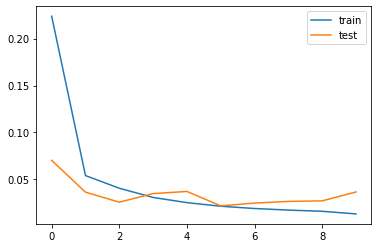

In [35]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train')
plt.plot(test_losses,label='test')
plt.legend()

I used cross entropy loss.   
The above trace plot shows that both train and test loss converge well.   
The model trained for 10 epoches, and it seems that the overfitting occurs after fifth epoch.